In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from PIL import Image

In [4]:
# Define paths
train_images_dir = '/content/drive/MyDrive/Traffic light detection/train/'
train_annotations_path = '/content/drive/MyDrive/Traffic light detection/train/annotations.csv'
test_images_dir = '/content/drive/MyDrive/Traffic light detection/test/'
test_annotations_path = '/content/drive/MyDrive/Traffic light detection/test/test_annotations1.csv'


In [5]:
# Load and preprocess annotations

def load_annotations(annotations_path):
    annotations = pd.read_csv(annotations_path)
    annotations = annotations[annotations['class'].isin(['TLS-R', 'TLS-G', 'TLS-Y'])]  # Filter relevant classes
    return annotations

train_annotations = load_annotations(train_annotations_path)
test_annotations = load_annotations(test_annotations_path)


In [6]:
# Load and preprocess images

def load_images(image_dir, annotations):
    images = []
    labels = []
    bboxes = []

    for _, row in annotations.iterrows():
        img_path = os.path.join(image_dir, row['filename'])

        if os.path.exists(img_path):
            image = Image.open(img_path)
            image = image.resize((224, 224))
            image = np.array(image) / 255.0

            images.append(image)
            labels.append(row['class'])

            # Normalize bounding boxes
            bbox = [row['xmin'] / row['width'], row['ymin'] / row['height'],
                    row['xmax'] / row['width'], row['ymax'] / row['height']]
            bboxes.append(bbox)

    images = np.array(images)
    bboxes = np.array(bboxes)
    labels = np.array(labels)

    return images, bboxes, labels

train_images, train_bboxes, train_labels = load_images(train_images_dir, train_annotations)
test_images, test_bboxes, test_labels = load_images(test_images_dir, test_annotations)


In [7]:
# Label encoding
label_mapping = {'TLS-R': 0, 'TLS-G': 1, 'TLS-Y': 2}
train_labels = np.array([label_mapping[label] for label in train_labels])
test_labels = np.array([label_mapping[label] for label in test_labels])

In [8]:
# Save processed data for quick loading
np.save('train_images.npy', train_images)
np.save('train_bboxes.npy', train_bboxes)
np.save('train_labels.npy', train_labels)
np.save('test_images.npy', test_images)
np.save('test_bboxes.npy', test_bboxes)
np.save('test_labels.npy', test_labels)

print('Data loading and preprocessing completed successfully!')


Data loading and preprocessing completed successfully!


In [9]:
# Model Building
input_image = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(input_image)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

In [10]:
# Output layers
class_output = layers.Dense(3, activation='softmax', name='class_output')(x)
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

model = keras.Model(inputs=input_image, outputs=[class_output, bbox_output])


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss={'class_output': 'sparse_categorical_crossentropy', 'bbox_output': 'mse'},
              metrics={'class_output': 'accuracy'})

In [12]:
# Train the model
history = model.fit(train_images, {'class_output': train_labels, 'bbox_output': train_bboxes},
                    validation_data=(test_images, {'class_output': test_labels, 'bbox_output': test_bboxes}),
                    epochs=10, batch_size=32)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - bbox_output_loss: 0.0416 - class_output_accuracy: 0.7458 - class_output_loss: 1.7758 - loss: 1.8179 - val_bbox_output_loss: 0.0267 - val_class_output_accuracy: 0.7190 - val_class_output_loss: 0.8210 - val_loss: 0.8069
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - bbox_output_loss: 0.0245 - class_output_accuracy: 0.7523 - class_output_loss: 0.7005 - loss: 0.7248 - val_bbox_output_loss: 0.0267 - val_class_output_accuracy: 0.7190 - val_class_output_loss: 0.7701 - val_loss: 0.7715
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - bbox_output_loss: 0.0256 - class_output_accuracy: 0.7800 - class_output_loss: 0.5681 - loss: 0.5938 - val_bbox_output_loss: 0.0265 - val_class_output_accuracy: 0.7397 - val_class_output_loss: 1.0046 - val_loss: 0.9806
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - bbox_output_loss: 0.0237 - class_output_accuracy: 0.8462 - class_output_loss: 0.4042 - loss: 0.4280 - val_bbox_output_loss: 0.0260 - v

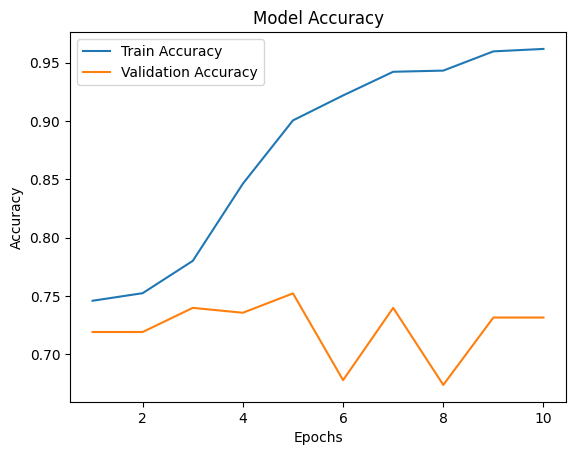

<Figure size 640x480 with 0 Axes>

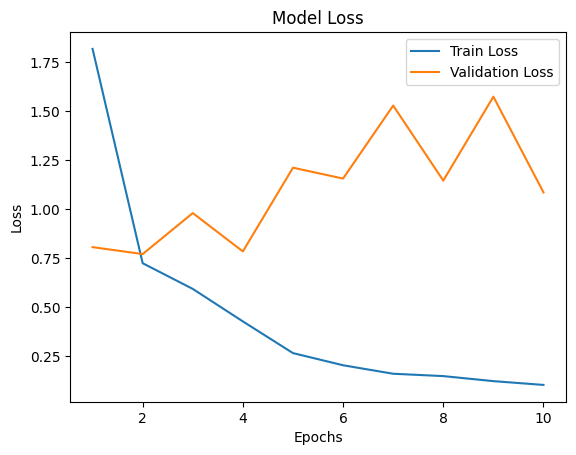

In [20]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)  # Assuming you have 10 epochs
train_accuracy = [0.7458, 0.7523, 0.7800, 0.8462, 0.9005, 0.9219, 0.9422, 0.9432, 0.9597, 0.9618]
val_accuracy = [0.7190, 0.7190, 0.7397, 0.7355, 0.7521, 0.6777, 0.7397, 0.6736, 0.7314, 0.7314]

plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

train_loss = [1.8179, 0.7248, 0.5938, 0.4280, 0.2664, 0.2044, 0.1611, 0.1491, 0.1234, 0.1041]
val_loss = [0.8069, 0.7715, 0.9806, 0.7851, 1.2120, 1.1568, 1.5289, 1.1463, 1.5743, 1.0862]

plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = model.predict(test_images)

# If predictions is a list, convert it to a NumPy array
if isinstance(predictions, list):
    predictions = np.array(predictions)

# Check the shape of predictions
print(predictions.shape)

# If predictions are in the shape (num_samples, num_classes), use np.argmax
if predictions.ndim == 2 and predictions.shape[1] > 1:
    predicted_classes = np.argmax(predictions, axis=1)  # For multi-class classification
else:
    # If it's binary classification, threshold the predictions
    predicted_classes = (predictions > 0.5).astype(int).flatten()  # Assuming binary classification

# Convert true labels from one-hot encoding to class labels
true_classes = np.argmax(test_labels, axis=1)  # This assumes test_labels is one-hot encoded

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['TLS-R', 'TLS-G', 'TLS-Y'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 242) + inhomogeneous part.

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Load processed data
train_images = np.load('train_images.npy')
train_bboxes = np.load('train_bboxes.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_bboxes = np.load('test_bboxes.npy')
test_labels = np.load('test_labels.npy')

# Make predictions on the test set
predictions = model.predict(test_images)

# If predictions is a list, convert it to a NumPy array
if isinstance(predictions, list):
    predictions = np.array(predictions)

# Check the shape of predictions
print(predictions.shape)  # This will help you understand the output format

# Adjust based on the shape
if predictions.ndim == 2 and predictions.shape[1] > 1:
    # For multi-class classification
    y_pred_classes = np.argmax(predictions, axis=1)  # Use axis=1 for class predictions
elif predictions.ndim == 1:
    # If it's a binary classification with a single output
    y_pred_classes = (predictions > 0.5).astype(int)  # Thresholding for binary classification
else:
    raise ValueError("Unexpected shape of predictions: {}".format(predictions.shape))

# Define class names based on your label mapping
label_mapping = {'TLS-R': 0, 'TLS-G': 1, 'TLS-Y': 2}
class_names = list(label_mapping.keys())  # ['TLS-R', 'TLS-G', 'TLS-Y']

# Visualize some predictions
plot_predictions(test_images, test_labels, y_pred_classes, class_names, num_images=10)

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 242) + inhomogeneous part.

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/Traffic light detection/traffic_light_model.keras')

print("Model training completed and saved.")

In [ ]:
# Encode labels for prediction
label_encoder = LabelEncoder()
label_encoder.fit(['TLS-G', 'TLS-R', 'TLS-Y'])

In [ ]:
# Uploading an image
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]

In [ ]:
# Load and preprocess the uploaded image
image = Image.open(image_filename)
image = image.resize((224, 224))
image = np.array(image) / 255.0
image_input = np.expand_dims(image, axis=0)

# Make predictions
class_pred, bbox_pred = model.predict(image_input)

In [ ]:
# Get the predicted class
predicted_class = np.argmax(class_pred, axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)

print(f'Predicted label: {predicted_label[0]}')
print(f'Predicted bounding box: {bbox_pred[0]}')

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# Define paths
train_images_dir = '/content/drive/MyDrive/Traffic light detection/train/'
train_annotations_path = '/content/drive/MyDrive/Traffic light detection/train/annotations.csv'
test_images_dir = '/content/drive/MyDrive/Traffic light detection/test/'
test_annotations_path = '/content/drive/MyDrive/Traffic light detection/test/test_annotations1.csv'

# Load and preprocess images
def load_images(image_dir, annotations):
    images = []
    labels = []
    bboxes = []

    for _, row in annotations.iterrows():
        img_path = os.path.join(image_dir, row['filename'])

        if os.path.exists(img_path):
            try:
                image = Image.open(img_path)
                image = image.resize((224, 224))  # Resize to match model input
                image = np.array(image) / 255.0  # Normalize to [0, 1]

                images.append(image)
                labels.append(row['class'])

                # Normalize bounding boxes
                bbox = [row['xmin'] / row['width'], row['ymin'] / row['height'],
                        row['xmax'] / row['width'], row['ymax'] / row['height']]
                bboxes.append(bbox)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    images = np.array(images)
    bboxes = np.array(bboxes)
    labels = np.array(labels)

    return images, bboxes, labels

# Load annotations
train_annotations = pd.read_csv(train_annotations_path)  # Load training annotations
test_annotations = pd.read_csv(test_annotations_path)  # Load testing annotations

# Encode labels
label_encoder = LabelEncoder()
train_annotations['class'] = label_encoder.fit_transform(train_annotations['class'])
test_annotations['class'] = label_encoder.transform(test_annotations['class'])

# Load images
train_images, train_bboxes, train_labels = load_images(train_images_dir, train_annotations)
test_images, test_bboxes, test_labels = load_images(test_images_dir, test_annotations)

# Check the shapes of the loaded data
print(f"Train images shape: {train_images.shape}")
print(f"Train bounding boxes shape: {train_bboxes.shape}")
print(f"Train labels shape: {train_labels.shape}")

print(f"Test images shape: {test_images.shape}")
print(f"Test bounding boxes shape: {test_bboxes.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Now you can proceed to use test_images, test_bboxes, and test_labels for evaluation or visualization

In [ ]:
pip install opencv-python

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
image_path = '/content/drive/MyDrive/Traffic light detection/test/427dT.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Define the bounding box using the provided coordinates
xmin, ymin, xmax, ymax = 432, 451, 504, 531
bounding_boxes = [(xmin, ymin, xmax, ymax)]  # List of bounding boxes

# Draw bounding boxes in red color
for (x1, y1, x2, y2) in bounding_boxes:
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color in BGR format

# Display the image with bounding boxes
cv2_imshow(image)
